## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Автор материала: Юрий Кашницкий (@yorko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 10 (демо)
## <center> Прогнозирование задержек вылетов

Ваша задача – побить единственный бенчмарк в [соревновании](https://www.kaggle.com/c/flight-delays-2017) на Kaggle Inclass. Подробных инструкций не будет, будет только тезисно описано, как получен этот бенчмарк. Конечно, с помощью Xgboost. Надеюсь, на данном этапе курса вам достаточно бросить полтора взгляда на данные, чтоб понять, что это тот тип задачи, в которой затащит Xgboost. Но проверьте еще Catboost.

## Обзор

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from scipy import sparse

from sklearn import model_selection
from sklearn.linear_model import LogisticRegressionCV

import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [ ]:
train = pd.read_csv("flight_delays_train.csv")
test = pd.read_csv("flight_delays_test.csv")

In [ ]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [ ]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


Уникальные значения

In [ ]:
#train.apply(lambda col: col.unique())
for col in list(train):
  print(col)
  print(np.sort(train[col].unique()))

Month
['c-1' 'c-10' 'c-11' 'c-12' 'c-2' 'c-3' 'c-4' 'c-5' 'c-6' 'c-7' 'c-8'
 'c-9']
DayofMonth
['c-1' 'c-10' 'c-11' 'c-12' 'c-13' 'c-14' 'c-15' 'c-16' 'c-17' 'c-18'
 'c-19' 'c-2' 'c-20' 'c-21' 'c-22' 'c-23' 'c-24' 'c-25' 'c-26' 'c-27'
 'c-28' 'c-29' 'c-3' 'c-30' 'c-31' 'c-4' 'c-5' 'c-6' 'c-7' 'c-8' 'c-9']
DayOfWeek
['c-1' 'c-2' 'c-3' 'c-4' 'c-5' 'c-6' 'c-7']
DepTime
[   1    2    3 ... 2522 2530 2534]
UniqueCarrier
['AA' 'AQ' 'AS' 'B6' 'CO' 'DH' 'DL' 'EV' 'F9' 'FL' 'HA' 'HP' 'MQ' 'NW'
 'OH' 'OO' 'TZ' 'UA' 'US' 'WN' 'XE' 'YV']
Origin
['ABE' 'ABI' 'ABQ' 'ABY' 'ACK' 'ACT' 'ACV' 'ACY' 'ADK' 'ADQ' 'AEX' 'AGS'
 'AKN' 'ALB' 'AMA' 'ANC' 'APF' 'ASE' 'ATL' 'ATW' 'AUS' 'AVL' 'AVP' 'AZO'
 'BDL' 'BET' 'BFL' 'BGM' 'BGR' 'BHM' 'BIL' 'BIS' 'BLI' 'BMI' 'BNA' 'BOI'
 'BOS' 'BPT' 'BQK' 'BQN' 'BRO' 'BRW' 'BTM' 'BTR' 'BTV' 'BUF' 'BUR' 'BWI'
 'BZN' 'CAE' 'CAK' 'CDC' 'CDV' 'CEC' 'CHA' 'CHO' 'CHS' 'CIC' 'CID' 'CLD'
 'CLE' 'CLL' 'CLT' 'CMH' 'CMI' 'COD' 'COS' 'CPR' 'CRP' 'CRW' 'CSG' 'CVG'
 'CWA' 'DAB' 'DAL' 'DAY

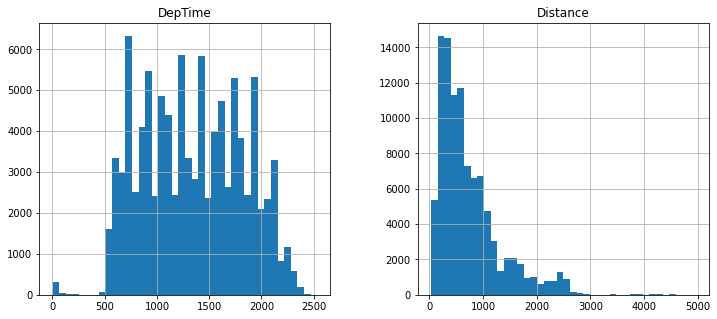

In [ ]:
train[['DepTime', 'Distance']].hist(bins=40, figsize=(12,5));

In [ ]:
train[train['Origin']==train['Dest']]

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min


In [ ]:
train.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1341.523880,729.39716
std,476.378445,574.61686
min,1.000000,30.00000
25%,931.000000,317.00000
50%,1330.000000,575.00000
75%,1733.000000,957.00000
max,2534.000000,4962.00000


In [ ]:
train.describe(include='O')

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,dep_delayed_15min
count,100000,100000,100000,100000,100000,100000,100000
unique,12,31,7,22,289,289,2
top,c-8,c-1,c-4,WN,ATL,ATL,N
freq,8830,3399,14736,15082,5834,5795,80956


In [ ]:
def check_duplicates(df, is_drop=True):
  '''
  Проверить наличие дубликатов в df. 
  Если is_drop=True (по умолчанию), дубликаты будут удалены из df.
  '''
  n_duplicates = len(df)-len(df.drop_duplicates()) #len(df['Col1'])-len(df['Col1'].drop_duplicates())
  if n_duplicates:
    print('Count of duplicates:', n_duplicates)
    if is_drop:
      print('Old DataFrame shape:', df.shape)
      df.drop_duplicates(inplace=True)
      print('New DataFrame shape:', df.shape)
  else:
    print('No duplicates')

check_duplicates(train)

No duplicates


## Baseline

Итак, надо по времени вылета самолета, коду авиакомпании-перевозчика, месту вылета и прилета и расстоянию между аэропортами вылета и прилета предсказать задержку вылета более 15 минут. В качестве простейшего бенчмарка возьмем логистическую регрессию и два признака, которые проще всего взять: `DepTime` и `Distance`. У такой модели результат – 0.68202 на LB. 

In [ ]:
X_train, y_train = (
    train[["Distance", "DepTime"]].values,
    train["dep_delayed_15min"].map({"Y": 1, "N": 0}).values,
)
X_test = test[["Distance", "DepTime"]].values

X_train_part, X_valid, y_train_part, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, random_state=17
)

In [ ]:
logit = LogisticRegression(random_state=17)

logit.fit(X_train_part, y_train_part)
logit_valid_pred = logit.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

0.6795697123357751

In [ ]:
logit.fit(X_train, y_train)
logit_test_pred = logit.predict_proba(X_test)[:, 1]

pd.Series(logit_test_pred, name="dep_delayed_15min").to_csv(
    "logit_2feat.csv", index_label="id", header=True
)

**Результат Kaggle:**

**auc_roc - 0.68202**

**место - 191 / 211 (90.5%)**

## Модель № 1

### Предобработка

Как был получен бенчмарк в соревновании:
- Признаки `Distance` и  `DepTime` брались без изменений
- Создан признак "маршрут" из исходных `Origin` и `Dest`
- К признакам `Month`, `DayofMonth`, `DayOfWeek`, `UniqueCarrier` и "маршрут" применено OHE-преобразование (`LabelBinarizer`)
- Выделена отложенная выборка
- Обучалась логистическая регрессия и градиентный бустинг (xgboost), гиперпараметры бустинга настраивались на кросс-валидации, сначала те, что отвечают за сложность модели, затем число деревьев фиксировалось равным 500 и настраивался шаг градиентного спуска
- С помощью `cross_val_predict` делались прогнозы обеих моделей на кросс-валидации (именно предсказанные вероятности), настраивалась линейная смесь ответов логистической регрессии и градиентного бустинга вида $w_1 * p_{logit} + (1 - w_1) * p_{xgb}$, где $p_{logit}$ – предсказанные логистической регрессией вероятности класса 1, $p_{xgb}$ – аналогично. Вес $w_1$ подбирался вручную. 
- В качестве ответа для тестовой выборки бралась аналогичная комбинация ответов двух моделей, но уже обученных на всей обучающей выборке.

Описанный план ни к чему не обязывает – это просто то, как решение получил автор задания. Возможно, мы не захотите следовать намеченному плану, а добавите, скажем, пару хороших признаков и обучите лес из тысячи деревьев.

Удачи!

Обработка признаков

In [ ]:
# Создаем Route, удаляем Origin и Dest
train1 = train.copy()
train1['Route'] = train1['Origin'] + '_' + train1['Dest']
train1.drop(columns=['Origin', 'Dest'], inplace=True)
train1.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Distance,dep_delayed_15min,Route
0,c-8,c-21,c-7,1934,AA,732,N,ATL_DFW
1,c-4,c-20,c-3,1548,US,834,N,PIT_MCO
2,c-9,c-2,c-5,1422,XE,416,N,RDU_CLE
3,c-11,c-25,c-6,1015,OO,872,N,DEN_MEM
4,c-10,c-7,c-6,1828,WN,423,Y,MDW_OMA


In [ ]:
test1 = test.copy()
test1['Route'] = test1['Origin'] + '_' + test1['Dest']
test1.drop(columns=['Origin', 'Dest'], inplace=True)
test1.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Distance,Route
0,c-7,c-25,c-3,615,YV,598,MRY_PHX
1,c-4,c-17,c-2,739,WN,1235,LAS_HOU
2,c-12,c-2,c-7,651,MQ,577,GSP_ORD
3,c-3,c-25,c-7,1614,WN,377,BWI_MHT
4,c-6,c-6,c-3,1505,UA,258,ORD_STL


In [ ]:
# Разделяем на X, y
X1 = train1.drop(columns='dep_delayed_15min')
y1 = train1['dep_delayed_15min'].map({'N':0, 'Y':1})
y1.unique()

array([0, 1])

In [ ]:
# Выделяем кат. признаки
cat_cols1 = X1.select_dtypes(include='O').columns.values
cat_cols1

array(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Route'],
      dtype=object)

In [ ]:
# Применяем OHE, объединяем с вещественными
ohe = OneHotEncoder(handle_unknown = 'ignore')
X1_cat = ohe.fit_transform(X1[cat_cols1])
X1_real = X1[list(set(X1.columns) - set(cat_cols1))].values
X1 = sparse.hstack((X1_cat, X1_real))
X1.shape

(100000, 4503)

In [ ]:
test1_cat = ohe.transform(test1[cat_cols1])
test1_real = test1[list(set(test1.columns) - set(cat_cols1))].values
test1 = sparse.hstack((test1_cat, test1_real))
test1.shape

(100000, 4503)

In [ ]:
# Разделение на обучение и валидацию
X1_train, X1_valid, y1_train, y1_valid = model_selection.train_test_split(X1, y1, test_size=0.2, random_state=0)

### Логистическая регрессия

In [ ]:
%%time
# Класс LogisticRegressionCV() создан специально для логистической регрессии 
# (для нее известны эффективные алгоритмы перебора параметров), для произвольной
# модели мы бы использовали др. (GridSearchCV, RandomizedSearchCV, hyperopt).
lr1 = LogisticRegressionCV(random_state=0, n_jobs=-1, scoring='roc_auc')
lr1.fit(X1_train, y1_train)

CPU times: user 183 ms, sys: 40 ms, total: 223 ms
Wall time: 4.99 s


In [ ]:
lr1.Cs_

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [ ]:
roc_auc_score(y1_valid, lr1.predict_proba(X1_valid)[:, 1])

0.6990322220242813

Добавим стандартизацию данных

In [ ]:
# Разделяем на X, y
X1_lr = train1.drop(columns='dep_delayed_15min')
y1_lr = train1['dep_delayed_15min'].map({'N':0, 'Y':1})

# Применяем OHE, объединяем с вещественными
scaler = StandardScaler()
X1_real_lr = scaler.fit_transform(X1_real)

X1_lr = sparse.hstack((X1_cat, X1_real_lr))

# Разделение на обучение и валидацию
X1_train_lr, X1_valid_lr, y1_train_lr, y1_valid_lr = model_selection.train_test_split(X1_lr, y1, test_size=0.2, random_state=0)

In [ ]:
%%time
lr1_lr = LogisticRegressionCV(random_state=0, n_jobs=-1, scoring='roc_auc')
lr1_lr.fit(X1_train_lr, y1_train)

CPU times: user 1.06 s, sys: 269 ms, total: 1.33 s
Wall time: 23.2 s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# Mean scores
lr1.scores_[1].mean(axis=0)

array([0.68367517, 0.68891075, 0.69153148, 0.69194319, 0.69194295,
       0.6919431 , 0.69194295, 0.6919433 , 0.69194319, 0.69194328])

In [ ]:
lr1.Cs_

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [ ]:
roc_auc_score(y1_valid, lr1_lr.predict_proba(X1_valid_lr)[:, 1])

0.7032674207143027

### XGBoost

In [ ]:
# Сначала обучим модель без подбора
dtrain = xgb.DMatrix(X1_train, y1_train)
dvalid = xgb.DMatrix(X1_valid, y1_valid)
params = {"objective": "binary:logistic", "max_depth": 3, "silent": 1, "eta": 0.1, "seed": 0}
# бинарная классификация, огранич. глубины дерева, убираем лишний вывод, шаг градиентного спуска
num_rounds = 50 # 50 итераций бустинга
xgb_model = xgb.train(params, dtrain, num_rounds)
preds_prob = xgb_model.predict(dvalid)

In [ ]:
xgb_model.predict(dvalid).shape

(20000,)

In [ ]:
roc_auc_score(y1_valid, preds_prob)

0.7175863231557287

In [ ]:
roc_auc_score(y1_valid, lr1.predict_proba(X1_valid)[:, 1])

0.6990322220242813

**Подбор гиперпараметров XGBoost**

Пример схемы подбора гиперпараметров. 

Разделим на две итерации.

Гиперпараметры, которые отвечают за:
1. Сложность 
* max_depth
* colsample by tree
* subsample
* $\gamma$ 
* $\alpha$
* $\lambda$

*(не обязательно все)*

Фиксируется num_round $\approx$ 20-30. Перебор по сетке параметров (GridSearch, 
RandomizedGridSearch, hyperopt...)

2. Оптимизацию
* num_round (n_estimators)
* learning_rate
lr фиксируем малым значением = 0.01 (0.003). Обучаем модель (не Grid, с критерием ранней остановки). По графику подбираем необходимое количество деревьев.


1. Гиперпараметры, отвечающие за сложность модели

In [ ]:
def score(params):
  print("Training with params:" , params)
  params["max_depth"] = int(params["max_depth"])
  dtrain = xgb.DMatrix(X1_train, label=y1_train)
  dvalid = xgb.DMatrix(X1_valid, label=y1_valid)
  model = xgb.train(params, dtrain, params["num_round"])
  predictions = model.predict(dvalid)#.reshape((X1_valid.shape[0], 2))
  score = -roc_auc_score(y1_valid, predictions) # Используется функция минимизации! Используем знак "-+"
  print("\tScore {0}\n".format(-score))
  return {"loss": score, "status": STATUS_OK}

In [ ]:
def optimize(trials):
  space = {
      "num_round": 30, # фиксируем, берем немного
      "max_depth": hp.choice('max_depth', np.arange(1, 12, dtype=int)), # hp.quniform("max_depth", 1, 12, 1),
      "min_child_weight": hp.choice('min_child_weight', np.arange(1, 10, dtype=int)), # hp.quniform("min_child_weight", 1, 10, 1),
      "colsample_bytree": hp.quniform("colsample_bytree", 0.4, 1, 0.05),
      "subsample": hp.quniform("subsample", 0.5, 1, 0.05),
      "gamma": hp.uniform("gamma", low=0, high=1),
      "lambda": hp.uniform(label='lambda', low=0, high=1),
      "eval_metric": "auc",
      "objective": "binary:logistic",
      "silent": 1,
      "seed": hp.choice('seed', np.arange(5, dtype=int)) # "seed": hp.quniform("seed", 1, 5, 1),
    }

  best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=20, show_progressbar=True)
  return best

In [ ]:
trials = Trials()
best_params = optimize(trials)

Training with params:
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.5143739494827824, 'lambda': 0.48036601836300785, 'max_depth': 11, 'min_child_weight': 8, 'num_round': 30, 'objective': 'binary:logistic', 'seed': 4, 'silent': 1, 'subsample': 0.5}
	Score 0.7309987365688617

Training with params:
{'colsample_bytree': 0.8500000000000001, 'eval_metric': 'auc', 'gamma': 0.3629491965403049, 'lambda': 0.0864683471044908, 'max_depth': 2, 'min_child_weight': 7, 'num_round': 30, 'objective': 'binary:logistic', 'seed': 1, 'silent': 1, 'subsample': 0.8}
	Score 0.7153613024214961

Training with params:
{'colsample_bytree': 0.7000000000000001, 'eval_metric': 'auc', 'gamma': 0.5143148911432855, 'lambda': 0.9468749362798785, 'max_depth': 5, 'min_child_weight': 2, 'num_round': 30, 'objective': 'binary:logistic', 'seed': 2, 'silent': 1, 'subsample': 0.75}
	Score 0.7286238121427064

Training with params:
{'colsample_bytree': 0.9, 'eval_metric': 'auc', 'gamma': 0.9935152089500294, 'lambda': 

In [ ]:
best_params

{'colsample_bytree': 0.55,
 'gamma': 0.5968542768022584,
 'lambda': 0.3103222449832985,
 'max_depth': 7,
 'min_child_weight': 3,
 'seed': 4,
 'subsample': 0.65}

In [ ]:
best_params['num_round'] = 30
best_params['eval_metric'] = "auc"
best_params['objective'] = 'binary:logistic'
best_params['silent'] = 1
best_params['learning_rate'] = 0.003

dtrain = xgb.DMatrix(X1_train, y1_train)

2. Гиперпараметры, отвечающие за оптимизацию

Подбор лучшего learning_rate, берем num_round=500

In [ ]:
def optimize(trials):
  space = best_params.copy()
  space['learning_rate'] = hp.uniform("learning_rate", low=0.005, high=0.05)
  space['num_round'] = 500
  best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=5, show_progressbar=True)
  return best

best_lr = optimize(Trials())

Training with params:
{'colsample_bytree': 0.55, 'eval_metric': 'auc', 'gamma': 0.5968542768022584, 'lambda': 0.3103222449832985, 'learning_rate': 0.04042985070025514, 'max_depth': 7, 'min_child_weight': 3, 'num_round': 500, 'objective': 'binary:logistic', 'seed': 4, 'silent': 1, 'subsample': 0.65}
	Score 0.7392327177462356

Training with params:
{'colsample_bytree': 0.55, 'eval_metric': 'auc', 'gamma': 0.5968542768022584, 'lambda': 0.3103222449832985, 'learning_rate': 0.04207524503748538, 'max_depth': 7, 'min_child_weight': 3, 'num_round': 500, 'objective': 'binary:logistic', 'seed': 4, 'silent': 1, 'subsample': 0.65}
	Score 0.7403290804620486

Training with params:
{'colsample_bytree': 0.55, 'eval_metric': 'auc', 'gamma': 0.5968542768022584, 'lambda': 0.3103222449832985, 'learning_rate': 0.044622570465446654, 'max_depth': 7, 'min_child_weight': 3, 'num_round': 500, 'objective': 'binary:logistic', 'seed': 4, 'silent': 1, 'subsample': 0.65}
	Score 0.7407264139868143

Training with para

In [ ]:
best_params['learning_rate'] = best_lr['learning_rate']
best_params

{'colsample_bytree': 0.55,
 'eval_metric': 'auc',
 'gamma': 0.5968542768022584,
 'lambda': 0.3103222449832985,
 'learning_rate': 0.044622570465446654,
 'max_depth': 7,
 'min_child_weight': 3,
 'num_round': 30,
 'objective': 'binary:logistic',
 'seed': 4,
 'silent': 1,
 'subsample': 0.65}

Фиксируем learning_rate, строим до 2000 деревьев, выбираем лучшее значение

In [ ]:
%%time
best_params.pop('num_round')
xgbCvResult = xgb.cv(best_params, dtrain, num_boost_round=2000, nfold=3, early_stopping_rounds=50)

CPU times: user 4min 40s, sys: 548 ms, total: 4min 40s
Wall time: 2min 22s


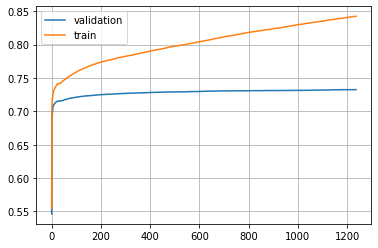

In [ ]:
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult["test-auc-mean"], label='validation')
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult["train-auc-mean"], label='train')
plt.legend(); plt.grid();

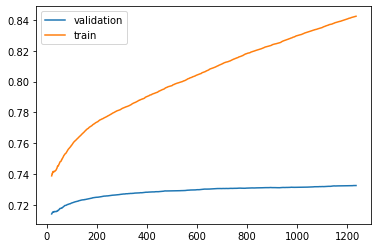

In [ ]:
start_from = 20
plt.plot(range(start_from, xgbCvResult.shape[0]), xgbCvResult["test-auc-mean"][start_from:], label='validation')
plt.plot(range(start_from, xgbCvResult.shape[0]), xgbCvResult["train-auc-mean"][start_from:], label='train')
plt.legend();

In [ ]:
print(f'Best estimators: {np.argmax(xgbCvResult["test-auc-mean"])},') 
best_num_round = np.argmax(xgbCvResult["test-auc-mean"])
print(f'Best auc_roc: {xgbCvResult["test-auc-mean"].max()}')

Best estimators: 1236,
Best auc_roc: 0.7325513333333333


Делаем прогноз 

In [ ]:
%%time
best_xgb1 = xgb.train(best_params, dtrain, num_boost_round=best_num_round)
xgb1_predict_pr_valid = best_xgb1.predict(dvalid)

CPU times: user 1min 31s, sys: 165 ms, total: 1min 31s
Wall time: 46.4 s


In [ ]:
roc_auc_score(y1_valid, xgb1_predict_pr_valid)

0.7426169656033875

In [ ]:
dtest = xgb.DMatrix(test1)
xgboost1_predict_pr_test = best_xgb1.predict(dtest)

pd.Series(xgboost1_predict_pr_test, name="dep_delayed_15min").to_csv(
    "xgb1_stand_algo.csv", index_label="id", header=True)

**Результат Kaggle:**

**auc_roc - 0.72008**

**место - 151 / 211 (71.6%)**

С помощью cross_val_predict делались прогнозы обеих моделей на кросс-валидации (именно предсказанные вероятности), настраивалась линейная смесь ответов логистической регрессии и градиентного бустинга вида  $w1∗plogit+(1−w1)∗pxgb$ , где  plogit  – предсказанные логистической регрессией вероятности класса 1,  pxgb  – аналогично. Вес  w1  подбирался вручную.

В качестве ответа для тестовой выборки бралась аналогичная комбинация ответов двух моделей, но уже обученных на всей обучающей выборке.

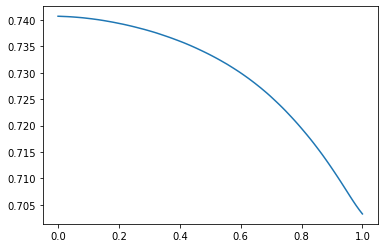

In [ ]:
# w = 0, logreg не используется
ww = np.linspace(0, 1, 100)
scores = []
for wi in ww:
  prob = wi * lr1_lr.predict_proba(X1_valid_lr)[:, 1] + (1-wi) * xgb12_predict_pr_valid
  roc_auc_score(y1_valid, prob)
  scores.append(roc_auc_score(y1_valid, prob))
plt.plot(ww, scores);

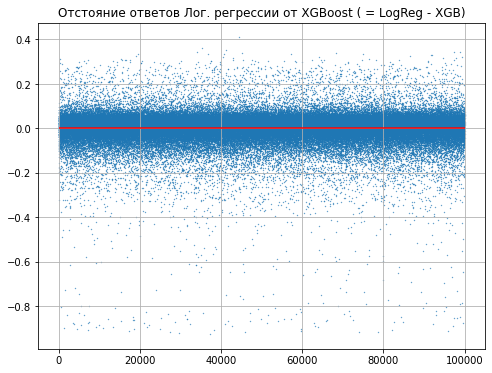

In [ ]:
plt.figure(figsize=(8, 6))
# Интересно посмотреть отстояния. Использую логрег без стандартизации (это проще), качество все-равно ниже
plt.scatter(range(len(xgboost12_predict_pr_test)), lr1.predict_proba(test1)[:, 1] - xgboost12_predict_pr_test, s=0.1)
plt.hlines(0, 0, 100000, colors='r'); plt.grid(); plt.title('Отстояние ответов Лог. регрессии от XGBoost (s = LogReg - XGB)');

Обучимся на всей выборке

In [ ]:
dtrain1_full = xgb.DMatrix(X1, y1)
best_xgb12 = xgb.train(best_params, dtrain1_full, num_boost_round=best_num_round)

xgboost12_predict_pr_test = best_xgb12.predict(dtest)
pd.Series(xgboost12_predict_pr_test, name="dep_delayed_15min").to_csv(
    "xgb12_stand_algo.csv", index_label="id", header=True)

**Результат Kaggle:**

**auc_roc - 0.72325**

**место - 122 / 211 (57.8%)**

## Модель № 2
**Проверим CatBoost**

2.1. Без настройки

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 67.3MB 45kB/s 


In [ ]:
# Разделяем на X, y
X2 = train1.drop(columns='dep_delayed_15min')
y2 = train1['dep_delayed_15min'].map({'N':0, 'Y':1})
cat_cols2 = cat_cols1

In [ ]:
X2_train, X2_valid, y2_train, y2_valid = train_test_split(X2, y2, test_size=0.2, random_state=0)

In [ ]:
%%time
model2 = CatBoostClassifier(custom_loss='AUC', use_best_model=True, random_seed=0)#, task_type='GPU') с GPU заметно проседает точность (auc_roc с 0,73 до 0,71!)...

model2.fit(
  X2_train, y2_train,
  cat_features=cat_cols2, 
  eval_set=(X2_valid, y2_valid), 
  logging_level='Silent')

score2 = model2.best_score_['validation']
# model2.get_all_params()

CPU times: user 3min 9s, sys: 3.59 s, total: 3min 13s
Wall time: 1min 40s


In [ ]:
score2

{'AUC': 0.735008955001831, 'Logloss': 0.42886142578125}

In [ ]:
test2 = test.copy()
test2['Route'] = test2['Origin'] + '_' + test2['Dest']
test2.drop(columns=['Origin', 'Dest'], inplace=True)
test2.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Distance,Route
0,c-7,c-25,c-3,615,YV,598,MRY_PHX
1,c-4,c-17,c-2,739,WN,1235,LAS_HOU
2,c-12,c-2,c-7,651,MQ,577,GSP_ORD
3,c-3,c-25,c-7,1614,WN,377,BWI_MHT
4,c-6,c-6,c-3,1505,UA,258,ORD_STL


In [ ]:
pd.Series(model2.predict_proba(test2)[:, 1], name="dep_delayed_15min").to_csv(
    "xgb2_stand_algo.csv", index_label="id", header=True)

**Результат Kaggle:**

**auc_roc - 0.72406**

**место - 117 / 211 (55.4%)**

In [ ]:
model2.predict_proba(test2)[:, 1]

array([0.02436365, 0.02246297, 0.02690595, ..., 0.18472875, 0.06728008,
       0.06970511])

In [ ]:
xgboost12_predict_pr_test

array([0.02450857, 0.03167284, 0.05705441, ..., 0.17780907, 0.08258546,
       0.07321338], dtype=float32)

Объединим XGBOOST и CatBoost

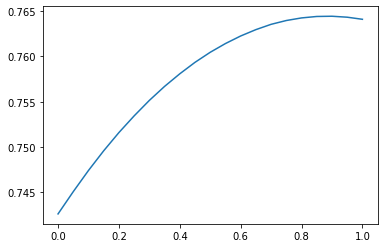

In [ ]:
ww = np.linspace(0, 1, 21)
scores = []
for wi in ww:
  prob = wi * model2.predict_proba(X2_valid)[:, 1] + (1-wi) * xgb1_predict_pr_valid
  scores.append(roc_auc_score(y1_valid, prob))
plt.plot(ww, scores);

In [ ]:
w1 = ww[np.argmax(scores)] 
w1

0.85

Обучение на всей выборке

In [ ]:
%%time
model22 = CatBoostClassifier(custom_loss='AUC', random_seed=0) 
#model22 = CatBoostClassifier(custom_loss='AUC', **model3.get_all_params, random_seed=0) #, task_type='GPU'
###!!!!!

model22.fit(
  X2, y2,
  cat_features=cat_cols2, 
  logging_level='Silent')

pd.Series(model22.predict_proba(test2)[:, 1], name="dep_delayed_15min").to_csv(
    "xgb22_stand_algo.csv", index_label="id", header=True)

CPU times: user 3min 43s, sys: 3.63 s, total: 3min 46s
Wall time: 1min 57s


**Результат Kaggle:**

**auc_roc - 0.73285**

**место - 34 / 211 (16.1%)**

На всей выборке объединенная модель

In [ ]:
prob23 = w1 * model22.predict_proba(test2)[:, 1] + (1-w1) * xgboost12_predict_pr_test

pd.Series(prob23, name="dep_delayed_15min").to_csv(
    "xgb23_stand_algo.csv", index_label="id", header=True)

**Результат Kaggle:**

**auc_roc - 0.73413**

**место - 29 / 211 (13.7%)**

**CatBoost подбор параметров**

Ниже описаны гиперпараметры (англ. hyperparameters), на которые стоит обратить внимание при использовании библиотеки.

* cat_features;
* Overfitting detector;
* Число итераций и learning rate;
* L2_reg;
* Random_srength;
* Bagging_temp;
* Глубина дерева (стоит попробовать 10 и 6).

In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV

model24 = CatBoostClassifier(custom_loss='AUC', task_type='GPU', random_seed=0)
parameters = {'learning_rate': [0.01, 0.02, 0.04, 0.1],
        'iterations': [500, 750, 1000, 1250, 1500, 2000],
        'depth': [4, 6, 8, 10, 12],
        'l2_leaf_reg': [3, 5, 7, 9]}

randm24 = RandomizedSearchCV(estimator=model24, param_distributions = parameters, 
                            cv = 3, n_iter = 10, n_jobs=-1)

randm24.fit(X2_train, y2_train,
  cat_features=cat_cols2, 
  eval_set=(X2_valid, y2_valid), 
  logging_level='Silent')

CPU times: user 46min 41s, sys: 9min 23s, total: 56min 4s
Wall time: 41min 33s


In [ ]:
randm24

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fc056660c10>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'depth': [4, 6, 8, 10, 12],
                                        'iterations': [500, 750, 1000, 1250,
                                                       1500, 2000],
                                        'l2_leaf_reg': [3, 5, 7, 9],
                                        'learning_rate': [0.01, 0.02, 0.04,
                                                          0.1]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [ ]:
randm24.best_params_

{'depth': 10, 'iterations': 1500, 'l2_leaf_reg': 7, 'learning_rate': 0.04}


In [ ]:
%%time
model24 = CatBoostClassifier(custom_loss='AUC', random_seed=0, **randm24.best_params_, task_type='GPU')

model24.fit(
  X2, y2,
  cat_features=cat_cols2, 
  logging_level='Silent')

pd.Series(model24.predict_proba(test2)[:, 1], name="dep_delayed_15min").to_csv(
    "xgb24_stand_algo.csv", index_label="id", header=True)

CPU times: user 35.6 s, sys: 8.08 s, total: 43.7 s
Wall time: 29.1 s


**Результат Kaggle** *(оказался чуть хуже)* **:**

**auc_roc - 0.73311**

## Модель № 3
**Предложим другие признаки**

In [ ]:
train3 = train.copy()

train3['Route'] = train1['Route'] # новые признаки и возможная логика
train3['DayofYear'] = train3['DayofMonth'] + '_' + train3['Month'] # может есть праздники и это влияет?
train3['UnCar_Orig'] = train3['UniqueCarrier'] + '_' + train3['Origin'] # зависит от компании в определенном аэропорте
# в этих двух признаках уверенности меньше:
train32 = train3.copy()
train32['Orig_Time'] = train32['Origin'] + '_' + train32['DepTime'].values.astype('str') # в разное время аэропорты загружены по-разному
train32['Orig_Dist'] = train32['Origin'] + '_' + train32['Distance'].values.astype('str') # может вне очереди пропускают близкие/дальние маршруты 
# выкинем возможно избыточные признаки
train33 = train3.copy()
train33 = train33.drop(columns=['DayofMonth', 'Dest'])

train34 = train32.copy()
train34 = train34.drop(columns=['DayofMonth', 'Dest'])

In [ ]:
test3 = test.copy()

test3['Route'] = test2['Route'] # новые признаки и возможная логика
test3['DayofYear'] = test3['DayofMonth'] + '_' + test3['Month'] # может есть праздники и это влияет?
test3['UnCar_Orig'] = test3['UniqueCarrier'] + '_' + test3['Origin'] # зависит от компании в определенном аэропорте
# в этих двух признаках уверенности меньше:
test32 = test3.copy()
test32['Orig_Time'] = test32['Origin'] + '_' + test32['DepTime'].values.astype('str') # в разное время аэропорты загружены по-разному
test32['Orig_Dist'] = test32['Origin'] + '_' + test32['Distance'].values.astype('str') # может вне очереди пропускают близкие/дальние маршруты 
# выкинем возможно избыточные признаки
test33 = test3.copy()
test33 = test33.drop(columns=['DayofMonth', 'Dest'])

test34 = test32.copy()
test34 = test34.drop(columns=['DayofMonth', 'Dest'])

In [ ]:
X3 = train3.drop(columns='dep_delayed_15min')
y3 = train3['dep_delayed_15min']

X32 = train32.drop(columns='dep_delayed_15min')
y32 = train32['dep_delayed_15min']

X33 = train33.drop(columns='dep_delayed_15min')
y33 = train33['dep_delayed_15min']

X34 = train34.drop(columns='dep_delayed_15min')
y34 = train34['dep_delayed_15min']

X3_train, X3_valid, y3_train, y3_valid = train_test_split(X3, y3, test_size=0.2, random_state=0)
X32_train, X32_valid, y32_train, y32_valid = train_test_split(X32, y32, test_size=0.2, random_state=0)
X33_train, X33_valid, y33_train, y33_valid = train_test_split(X33, y33, test_size=0.2, random_state=0)
X34_train, X34_valid, y34_train, y34_valid = train_test_split(X34, y34, test_size=0.2, random_state=0)

In [ ]:
X3.head(3)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,Route,DayofYear,UnCar_Orig
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,ATL_DFW,c-21_c-8,AA_ATL
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,PIT_MCO,c-20_c-4,US_PIT
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,RDU_CLE,c-2_c-9,XE_RDU


In [ ]:
cat_cols3 = X3.select_dtypes(include='O').columns.values
cat_cols3

array(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin',
       'Dest', 'Route', 'DayofYear', 'UnCar_Orig'], dtype=object)

In [ ]:
cat_cols32 = X32.select_dtypes(include='O').columns.values
cat_cols33 = X33.select_dtypes(include='O').columns.values
cat_cols34 = X34.select_dtypes(include='O').columns.values

In [ ]:
%%time
def train_cat_boost_with_valid(X_tr, y_tr, X_val, y_val, cat_feat):
  model = CatBoostClassifier(custom_loss='AUC', use_best_model=True, random_seed=0)

  model.fit(
    X_tr, y_tr,
    cat_features=cat_feat, 
    eval_set=(X_val, y_val), 
    logging_level='Silent')

  score = model.best_score_['validation']
  return model, score

model3, score3 = train_cat_boost_with_valid(X3_train, y3_train, X3_valid, y3_valid, cat_cols3)
model32, score32 = train_cat_boost_with_valid(X32_train, y32_train, X32_valid, y32_valid, cat_cols32)
model33, score33 = train_cat_boost_with_valid(X33_train, y33_train, X33_valid, y33_valid, cat_cols33)
model34, score34 = train_cat_boost_with_valid(X34_train, y34_train, X34_valid, y34_valid, cat_cols34)

CPU times: user 22min 55s, sys: 22.5 s, total: 23min 18s
Wall time: 12min 2s


In [ ]:
print('Score of Model3 :', score3)
print('Score of Model32:', score32)
print('Score of Model33:', score33)
print('Score of Model34:', score34)

Score of Model3: {'Logloss': 0.40423375237172915, 'AUC': 0.7711218694404569}
Score of Model32: {'Logloss': 0.39864826142635484, 'AUC': 0.7826523865401996}
Score of Model33: {'Logloss': 0.40611705326944614, 'AUC': 0.7667204856876376}
Score of Model34: {'Logloss': 0.4021839174690759, 'AUC': 0.7767260647923353}


In [ ]:
%%time
# Обучим модель 3.2 на всей выборке
model322 = CatBoostClassifier(custom_loss='AUC', random_seed=0) 

model322.fit(
  X32, y32,
  cat_features=cat_cols32, 
  logging_level='Silent')

pd.Series(model322.predict_proba(test32)[:, 1], name="dep_delayed_15min").to_csv(
    "xgb322_stand_algo.csv", index_label="id", header=True)

CPU times: user 8min, sys: 6.07 s, total: 8min 6s
Wall time: 4min 10s


**Результат Kaggle:**

**auc_roc - 0.73295**

*чуть лучше одиночной модели CatBoost (0.73285)*

In [ ]:
%%time
# Обучим модель 3 на всей выборке
model312 = CatBoostClassifier(custom_loss='AUC', random_seed=0) 

model312.fit(
  X3, y3,
  cat_features=cat_cols3, 
  logging_level='Silent')

pd.Series(model312.predict_proba(test3)[:, 1], name="dep_delayed_15min").to_csv(
    "xgb312_stand_algo.csv", index_label="id", header=True)

CPU times: user 5min 58s, sys: 5.83 s, total: 6min 4s
Wall time: 3min 7s


**Результат Kaggle: model 312**

**auc_roc - 0.73485**

**место - 24 / 211 (11.4%)**

In [ ]:
%%time
# Обучим модель 3.3 на всей выборке
model332 = CatBoostClassifier(custom_loss='AUC', random_seed=0) 

model332.fit(
  X33, y33,
  cat_features=cat_cols33, 
  logging_level='Silent')

pd.Series(model332.predict_proba(test33)[:, 1], name="dep_delayed_15min").to_csv(
    "xgb332_stand_algo.csv", index_label="id", header=True)

CPU times: user 4min 44s, sys: 4.56 s, total: 4min 49s
Wall time: 2min 29s


In [ ]:
%%time
# Обучим модель 3.4 на всей выборке
model342 = CatBoostClassifier(custom_loss='AUC', random_seed=0) 

model342.fit(
  X34, y34,
  cat_features=cat_cols34, 
  logging_level='Silent')

pd.Series(model342.predict_proba(test34)[:, 1], name="dep_delayed_15min").to_csv(
    "xgb342_stand_algo.csv", index_label="id", header=True)

CPU times: user 6min 23s, sys: 5.9 s, total: 6min 29s
Wall time: 3min 20s


**Результат Kaggle:**

**model 312: auc_roc - 0.73485**

**model 322: auc_roc - 0.73295**

**model 332: auc_roc - 0.72995**

**model 342: auc_roc - 0.73104**

Добавим к модели312 XGBoost

w1 = 0.8500000000000001


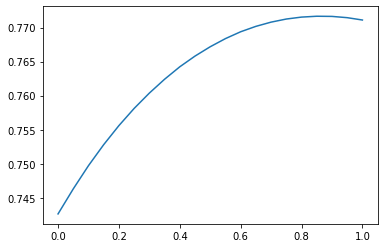

In [ ]:
ww = np.linspace(0, 1, 21)
scores = []
for wi in ww:
  prob = wi * model3.predict_proba(X3_valid)[:, 1] + (1-wi) * xgb1_predict_pr_valid
  scores.append(roc_auc_score(y1_valid, prob))
plt.plot(ww, scores)
w1 = ww[np.argmax(scores)]
print('w1 =', w1)

In [ ]:
prob35 = w1 * model312.predict_proba(test3)[:, 1] + (1-w1) * xgboost12_predict_pr_test

pd.Series(prob35, name="dep_delayed_15min").to_csv(
    "xgb35_stand_algo.csv", index_label="id", header=True)

**Результат Kaggle: model 312 + XGB**

**auc_roc - 0.73672**

**место - 19 / 211 (9.0%)**

In [ ]:
print('Предобработанные данные для CatBoost')
test3.head()

Предобработанные данные для CatBoost


,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,Route,DayofYear,UnCar_Orig
0,c-7,c-25,c-3,615,YV,MRY,PHX,598,MRY_PHX,c-25_c-7,YV_MRY
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235,LAS_HOU,c-17_c-4,WN_LAS
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577,GSP_ORD,c-2_c-12,MQ_GSP
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377,BWI_MHT,c-25_c-3,WN_BWI
4,c-6,c-6,c-3,1505,UA,ORD,STL,258,ORD_STL,c-6_c-6,UA_ORD


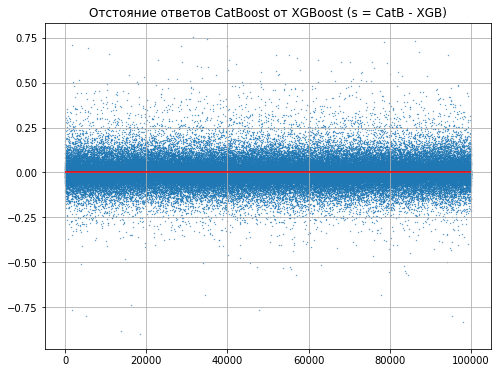

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(xgboost12_predict_pr_test)), model312.predict_proba(test3)[:, 1] - xgboost12_predict_pr_test, s=0.1)
plt.hlines(0, 0, 100000, colors='r'); plt.grid(); plt.title('Отстояние ответов CatBoost от XGBoost (s = CatB - XGB)');

## **Итоговая модель**

**Test auc_roc - 0.73672. Место - 19 / 211 (Top 9.0%)**


1. **X**

X.Route = X.Origin_X.Dest<br>

2. **X1**

X1_cat = OneHotEncoder(X[cat])

X1_real = X[real]

X1 = Union(X1_cat, X1_real)

3. **XGB**

$pxgb(X) = XGBoost${
  
 > 'colsample_bytree': 0.55,
 >
 > 'eval_metric': 'auc',
 >
 > 'gamma': 0.5968542768022584,
 >
 > 'lambda': 0.3103222449832985,
 >
 > 'learning_rate': 0.044622570465446654,
>
 > 'max_depth': 7,
>
 > 'min_child_weight': 3,
>
 > 'num_round': 30,
>
 > 'objective': 'binary:logistic',
>
 > 'seed': 4,
>
 > 'silent': 1,
>
 > 'subsample': 0.65,
>
 > 'num_round': 1236
>
 }(X)

4. **X2**

X2 = X

X2.Route = X.Route

X2.DayofYear = X2.DayofMonth_X2.Month

X2.UnCar_Orig = X2.UniqueCarrier'_'X2.Origin

5. **CatBoost**

$pcatb(X) = CatBoost(X2)$

6. **a(x)**

$w1 = 0.85$

$a(x) = w1∗plogit+(1−w1)∗pcatb$ 

$a(x) = 0.85∗plogit+0.15∗pcatb$ 